In [1]:
import numpy as np
import re

In [88]:
import time

In [2]:
import os.path

In [ ]:
from statistics import mean
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class LSHtree:
    def __init__(self):

        self.left = None
        self.right = None
        self.index = None
        self.bit = None
        
        self.used_hashes = []


    def print_node(self):
        print("Index :",self.index)
        print("Bit :",self.bit)
        

In [4]:
def print_tree(tree):
    if tree==None:
        return
    tree.print_node()
    print("Left Child")
    print_tree(tree.left)
    print("Right Child")
    print_tree(tree.right)

In [5]:
def get_num_nodes(tree):
    if tree == None:
        return 0
    total = 1
    total += get_num_nodes(tree.left)
    total += get_num_nodes(tree.right)
    return total

In [6]:
def get_sub_content(file_content):
    start=1
    while (file_content[start] != "{"):
        if file_content[start] == "}":
            return ("",-1,-1)
        start += 1
    
    end = start + 1
    num_left = 1
    num_right = 0
    N = len(file_content)
    while (num_left > num_right) and (end < N):
        if file_content[end] == "{":
            num_left += 1
        elif file_content[end] == "}":
            num_right += 1
        end += 1
    
    return (file_content[start:end+1], start, end)

In [91]:
def read_hash(file_content, used_hashes):
    tree = LSHtree()
    if len(file_content)==0:
        return None
    hash_str = re.findall("\([0,1,2],[0-9]+\)",file_content)[0]
    tree.bit = int(hash_str[1])
    tree.index = int(re.findall(",[0-9]+",hash_str)[0][1:])
    
    
    left_cont, s_l, e_l = get_sub_content(file_content)
    if len(left_cont) == 0:
        right_cont = ""
    else:
        right_cont, _, _ = get_sub_content(file_content[:s_l] + file_content[e_l+1:])
    
    tree.used_hashes = used_hashes + [(tree.bit, tree.index)]
    
    tree.left = read_hash(left_cont, tree.used_hashes)
    tree.right = read_hash(right_cont, tree.used_hashes)
    
    
    return tree
    

In [92]:
def read_tree(hashfile, filename):
    content = hashfile.read()
    #print(len(content))
    if len(content)==0:
        #print("returning")
        return
    
    new_content = "{ (2,2)" + content[2:][:-1]
    #print(new_content)
    #print("----------")
    tree = read_hash(new_content, [])
    #print(tree)
    return tree

In [93]:
def read_all_trees(hash_dir):
    trees = []
    num_trees = 300
    start=0
    for t in range(start, start + num_trees):
        filename = hash_dir + "/hashes" + str(t) 
        
        if not os.path.isfile(filename):
            continue
            
        with open(filename, "r") as hashfile:
            trees.append(read_tree(hashfile, filename))
    return trees

### Load MNIST Hashes

In [101]:
path = "/Users/dbeaglehole/Desktop/Research/instance_optimal_LSH/MNIST_hashes/"
hash_keys = ["hashesLong_c1","hashesLong_c1o2","hashesv1_c1.5","hashesv1_c4","hashesv1_c10"]
#hash_dirs = [path + x for x in hash_dirs]
trees_dict = {}
for hash_key in hash_keys:
    hash_dir = path + hash_key
    trees = read_all_trees(hash_dir)
    trees = [t for t in trees if t != None]
    trees_dict[hash_key] = trees

#### Load Dataset

In [102]:
datafile = '/Users/dbeaglehole/Desktop/Research/instance_optimal_LSH/mnist_data.txt'
dataset = np.loadtxt(datafile)

In [103]:
num_images, dim = dataset.shape
num_images, dim 

(750, 784)

### Generate Uniform Tree

In [104]:
import random 

In [105]:
bucket_size=5

In [152]:
def hash_d(dataset, used_hashes, get_indices=False):
    hashed_dataset = np.copy(dataset)
    indices = np.arange(dataset.shape[0])
    for bit, index in used_hashes:
        if bit==2:
            continue
        if get_indices:
            indices = indices[np.nonzero(hashed_dataset[:,index] == bit)]
        hashed_dataset = hashed_dataset[np.nonzero(hashed_dataset[:,index] == bit)]
    if get_indices:
        return indices
    return hashed_dataset

In [107]:
def generate_uniform_tree(used_hashes, dataset):
    
    hashed_dataset = hash_d(dataset, used_hashes)
    #print(hashed_dataset.shape[0])
    tree = LSHtree()
    tree.bit = used_hashes[-1][0]
    tree.index = used_hashes[-1][1]
    if hashed_dataset.shape[0] <= bucket_size:
        return tree
    
    idx = random.randint(0, dim-1)
    
    tree.left = generate_uniform_tree(used_hashes + [(1,idx)], hashed_dataset)
    tree.right = generate_uniform_tree(used_hashes + [(0,idx)], hashed_dataset)
    
    tree.used_hashes = used_hashes
    return tree
    

In [108]:
num_trees=110
uniform_trees = []
for t in range(num_trees):
    if (t%5==0):
        print("uniform tree %d/%d" % (t+1,num_trees))
    tree = generate_uniform_tree([(2,2)],dataset)
    uniform_trees.append(tree)

uniform tree 1/110
uniform tree 6/110
uniform tree 11/110
uniform tree 16/110
uniform tree 21/110
uniform tree 26/110
uniform tree 31/110
uniform tree 36/110
uniform tree 41/110
uniform tree 46/110
uniform tree 51/110
uniform tree 56/110
uniform tree 61/110
uniform tree 66/110
uniform tree 71/110
uniform tree 76/110
uniform tree 81/110
uniform tree 86/110
uniform tree 91/110
uniform tree 96/110
uniform tree 101/110
uniform tree 106/110


In [187]:
trees_dict['uniform'] = uniform_trees

### Generate Queries

In [109]:
#originally r = 10
r=10

In [110]:
def rand_flip(image, dim):
    new_query = np.copy(image)
    for i in range(r):
        rand_idx = random.randint(0,dim-1)
        new_query[rand_idx] = not new_query[rand_idx]
    return new_query

In [176]:
def generate_random_queries(dataset):
    query_list = []
    queries_per_img = 2
    num_images, dim = dataset.shape
    for i in range(num_images):
        image = dataset[i]
        for j in range(queries_per_img):
            flipped_query = rand_flip(image,dim)
            query_list.append((flipped_query,i))
    return query_list

In [177]:
def flip_on_bits(image, bits):
    query = np.copy(image)
    for _, idx in bits:
        query[idx] = (not image[idx])*1
    return query

In [178]:
query_list = generate_random_queries(dataset)

### Eval Optimized

In [179]:
def eval_tree(tree, query, datapoint, bucket_bool=False):
    if (tree.left == None) and (tree.right == None): #leaf
        if not bucket_bool:
            return 1, []
        else:
            return 1, tree.used_hashes
    
    index = tree.left.index
    
    if (query[index] == datapoint[index] == 1):
        return eval_tree(tree.left, query, datapoint)
        
    elif (query[index] == datapoint[index] == 0):
        return eval_tree(tree.right, query, datapoint)
        
    else:
        if not bucket_bool:
            return 0, []
        else:
            return 0, []

### Construct Rate vs Recall Curve

In [182]:
def compute_near_neighbors(query,i):
    nns = []
    for img_idx in range(dataset.shape[0]):
        img = dataset[img_idx,:]
        distance = np.sum(np.abs(img-query))
        if distance <= r:
            nns.append(img_idx)
    return nns

In [227]:
near_neighbors_list = []

def compute_recall_stats(trees):
    recalls = []
    query_times = []
    
    for j, (query,i) in enumerate(query_list):
        if j%200==0:
            print(j)
        #compute near neighbors
        if len(near_neighbors_list) < (j+1): #if NNs not added
            near_neighbors = compute_near_neighbors(query,i)
            near_neighbors_list.append(near_neighbors)
        else:
            near_neighbors = near_neighbors_list[j]
        
        #time query trees
        #start = time.time()
        #for tree in trees:
        #    eval_tree(tree, query, dataset[i])[0]:
        #end = time.time()
        
        #query_time = (end - start)
        #query_times.append(query_time)
        
        #scan buckets for near neighbors
        bucket_points = []
        for tree in trees:
            start = time.time()
            found, used_hashes = eval_tree(tree, q, dataset[i], bucket_bool=True)
            end = time.time()
            query_time = (end - start)
            query_times.append(query_time)
        
            bucket_indices = hash_d(dataset, used_hashes, get_indices=True)
            if found:
                bucket_points += list(bucket_indices)
        
        total_num_nns = 0
        for point in near_neighbors:
            if point in bucket_points:
                total_num_nns += 1
        
        #compute recall 
        recalls.append(total_num_nns/len(near_neighbors))
    
    #num_Qs = len(query_times)
    query_times = sorted(query_times)[:int(0.7*num_Qs)]
    return (sum(recalls)/len(recalls), len(query_times)/sum(query_times))
        

In [215]:
num_start = 10
num_end = 111
step = 10

In [218]:
recall_stats_per_tree = {}
for num_trees in range(num_start,num_end,step):
    print("Num trees",num_trees)
    for tree_key, trees in trees_dict.items():
        print("Key",tree_key)
        #if tree_key == "uniform" or tree_key == "hashesLong_c1o2":
        if tree_key not in recall_stats_per_tree:
            recall_stats_per_tree[tree_key] = []

        avg_recall, avg_query_time = compute_recall_stats(trees[:num_trees])
        recall_stats_per_tree[tree_key].append((avg_recall,avg_query_time))

Num trees 10
Key hashesLong_c1
Key hashesLong_c1o2
0
200
400
600
800
1000
1200
1400
Key hashesv1_c1.5
Key hashesv1_c4
Key hashesv1_c10
Key uniform
0
200
400
600
800
1000
1200
1400
Num trees 110
Key hashesLong_c1
Key hashesLong_c1o2
0
200
400
600
800
1000
1200
1400
Key hashesv1_c1.5
Key hashesv1_c4
Key hashesv1_c10
Key uniform
0
200
400
600
800
1000
1200
1400


In [219]:
recall_stats_per_tree.items()

dict_items([('hashesLong_c1o2', [(0.037333333333333336, 93600.29278656039), (0.26, 91861.48280215819)]), ('uniform', [(0.025333333333333333, 71686.31222247923), (0.21866666666666668, 70659.22181963126)])])

hashesLong_c1o2
[(0.037333333333333336, 93600.29278656039), (0.26, 91861.48280215819)]
uniform
[(0.025333333333333333, 71686.31222247923), (0.21866666666666668, 70659.22181963126)]


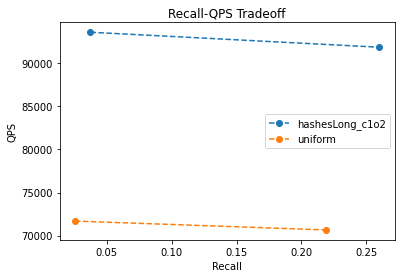

In [233]:
plt.figure()
plt.title("Recall-QPS Tradeoff")
plt.xlabel("Recall")
plt.ylabel("QPS")


for key,val in recall_stats_per_tree.items():
    print(key)
    print(val)
    plt.plot(*zip(*val), 'o--', label=key)
    
plt.legend(loc='center right')
plt.savefig("./qps_recall.png")
plt.show()

### Time Random Queries

In [787]:
import time

In [734]:
trees_dict["uniform"] = [uniform_trees]

In [61]:
time_dict = {}
for tree_key, trees in trees_dict.items():
    times = []
    for q,i in query_list:
        if (t%10000==0):
            print("itr ",t)
        start = time.time()
        for tree in trees:
            if eval_tree(tree, q, dataset[i]):
                break
        end = time.time()
        time_dict[tree_key] = (end - start)
        
    time_list.append(times)

NameError: name 'time' is not defined

In [736]:
for times in time_list:
    print(max(times))

0.009618282318115234
0.004235744476318359


In [737]:
for times in time_list:
    print(sum(times)/len(times))

4.8833534240722656e-05
3.512204742431641e-05


### Compute Recall for Random Queries

In [59]:
p_success_list = []
for tree_key,trees in trees_dict.items():
    p_success = []
    t=0
    for q,i in query_list:
        if (t%10000==0):
            print("itr ",t)
        total = 0
        for tree in trees:
            succ = eval_tree(tree, q, dataset[i])
            total += succ
        p_success.append(total/len(trees))
        t+=1
    p_success_list.append(p_success)

itr  0
itr  10000
itr  20000
itr  30000
itr  0
itr  10000
itr  20000
itr  30000
itr  0
itr  10000
itr  20000
itr  30000
itr  0
itr  10000
itr  20000
itr  30000
itr  0
itr  10000
itr  20000
itr  30000


### Eval Uniform

In [60]:
p_success_uniform = []
t=0
for q,i in query_list:
    if (t%10000==0):
        print("itr ",t)
    total = 0
    for tree in uniform_trees:
        total += eval_tree(tree, q, dataset[i])
    p_success_uniform.append(total/len(uniform_trees))
    t+=1

itr  0
itr  10000
itr  20000
itr  30000


## Plotting

In [65]:
n_bins = 20

In [66]:
n = len(p_success)

In [856]:
m=10000
sorted_opt = sorted(p_success)[:m]
sorted_uni = sorted(p_success_uniform)[:m]
mean(sorted_opt)/mean(sorted_uni)

0.9806995446743526

In [67]:
for p_success in p_success_list:
    print(mean(p_success))
print(mean(p_success_uniform))

0.8770753153153154
0.8782336182336182
0.8379941242937853
0.8395494193548387
0.7841898666666667
0.7363212121212122


In [71]:
order = ['ρ=1', 'ρ=0.83', 'ρ=0.67','ρ=0.25','ρ=0.1',"uni"]

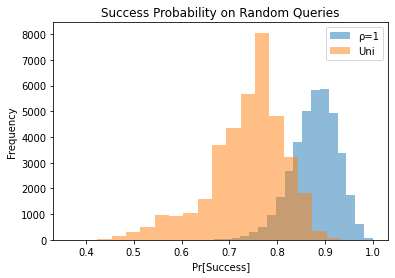

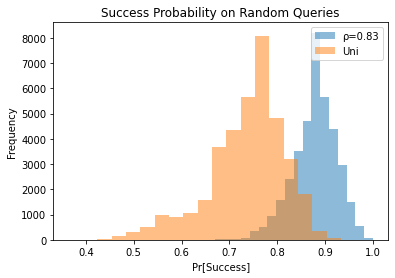

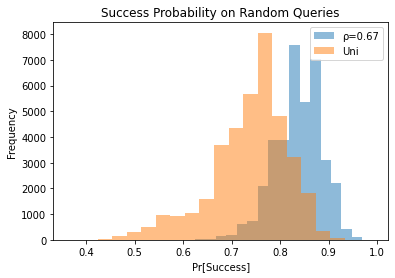

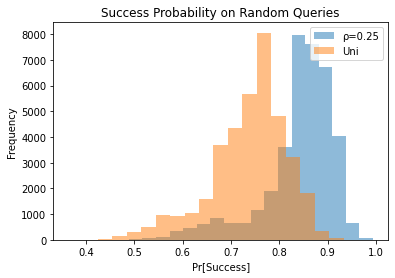

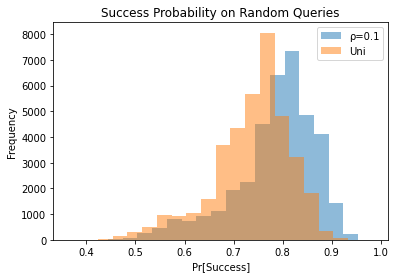

In [72]:
for i, p_success in enumerate(p_success_list):
    plt.figure()
    plt.hist(p_success, n_bins, alpha=0.5, label=order[i])
    plt.hist(p_success_uniform, n_bins, alpha=0.5, label='Uni')
    plt.legend(loc='upper right')
    plt.title("Success Probability on Random Queries")
    plt.xlabel("Pr[Success]")
    plt.ylabel("Frequency")
    #plt.savefig("./comparison" + order[i] + ".png")
    plt.show()